In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pydicom

import torch
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from CapsuleNet import CapsuleNetwork, CapsuleLoss

In [2]:
seed = 41
batch_size = 10
image_size = 128
num_classes = 2

np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
class DICOMDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for class_label, class_dir in enumerate(os.listdir(root_dir)):
            class_folder = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith('.dcm'):
                        self.image_paths.append(os.path.join(class_folder, file_name))
                        self.labels.append(class_label)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        dicom_image = pydicom.dcmread(img_path)
        image = dicom_image.pixel_array
        image = Image.fromarray(np.uint8(image))
        if self.transform:
            image = self.transform(image)
        label = self.labels[index]
        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
train_dir = "./data/CT/train"
test_dir = "./data/CT/test"

train_dataset = DICOMDataset(root_dir=train_dir, transform=transform)
test_dataset = DICOMDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

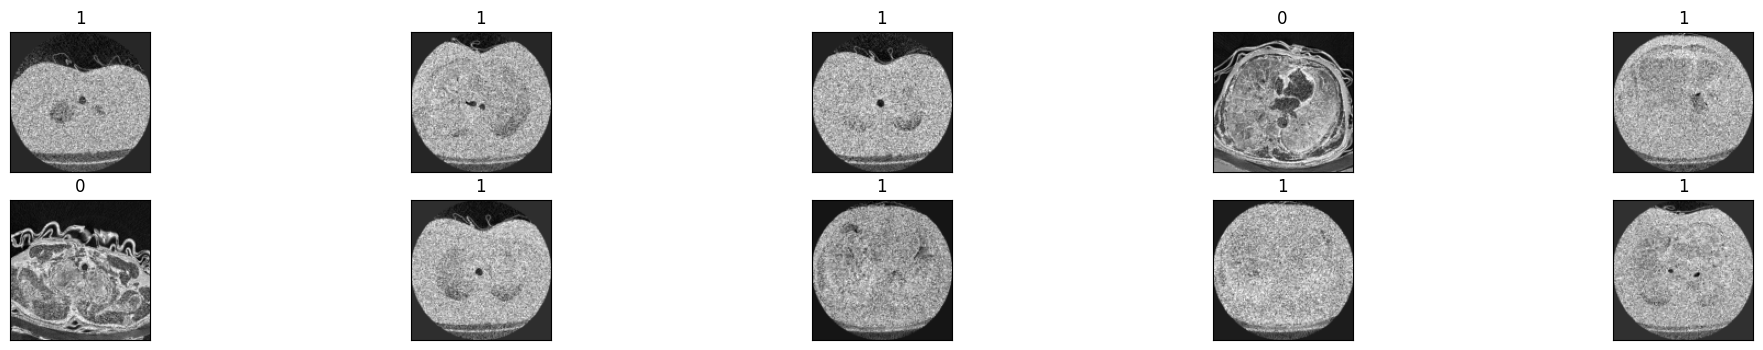

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [7]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=num_classes, train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [11]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

Epoch: 1 	Training Loss: 2.43578029
Epoch: 1 	Training Loss: 1.31889188
Epoch: 1 	Training Loss: 1.37406600
Epoch: 1 	Training Loss: 1.46986568
Epoch: 1 	Training Loss: 1.53570735
Epoch: 1 	Training Loss: 1.57842720
Epoch: 1 	Training Loss: 1.13949275
Epoch: 1 	Training Loss: 1.40810132
Epoch: 1 	Training Loss: 1.26362348
Epoch: 1 	Training Loss: 1.38902152
Epoch: 1 	Training Loss: 1.26272500
Epoch: 2 	Training Loss: 2.54850662
Epoch: 2 	Training Loss: 1.26542342
Epoch: 2 	Training Loss: 1.55870807
Epoch: 2 	Training Loss: 1.25450218
Epoch: 2 	Training Loss: 1.13387144
Epoch: 2 	Training Loss: 1.39183414
Epoch: 2 	Training Loss: 1.28355718
Epoch: 2 	Training Loss: 1.38903558
Epoch: 2 	Training Loss: 1.37676680
Epoch: 2 	Training Loss: 1.17774665
Epoch: 2 	Training Loss: 1.20512605
Epoch: 3 	Training Loss: 2.91687286
Epoch: 3 	Training Loss: 1.08263505
Epoch: 3 	Training Loss: 1.17795360
Epoch: 3 	Training Loss: 1.07649744
Epoch: 3 	Training Loss: 1.13584244
Epoch: 3 	Training Loss: 1.1

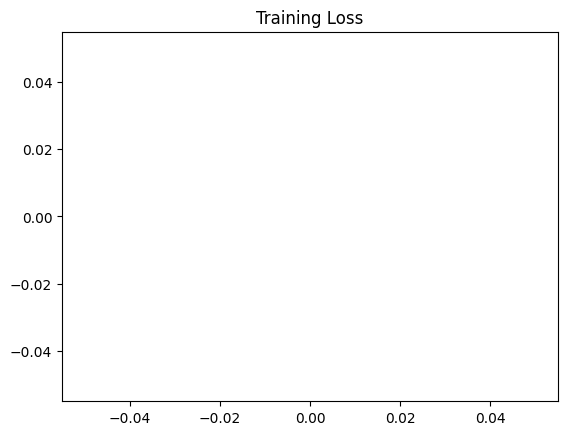

In [10]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [12]:
def display_images(images, reconstructions):
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, image_size, image_size)
    reconstructions = reconstructions.data.cpu().numpy()
    fig, axs = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))
    for images, row in zip([images, reconstructions], axs):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

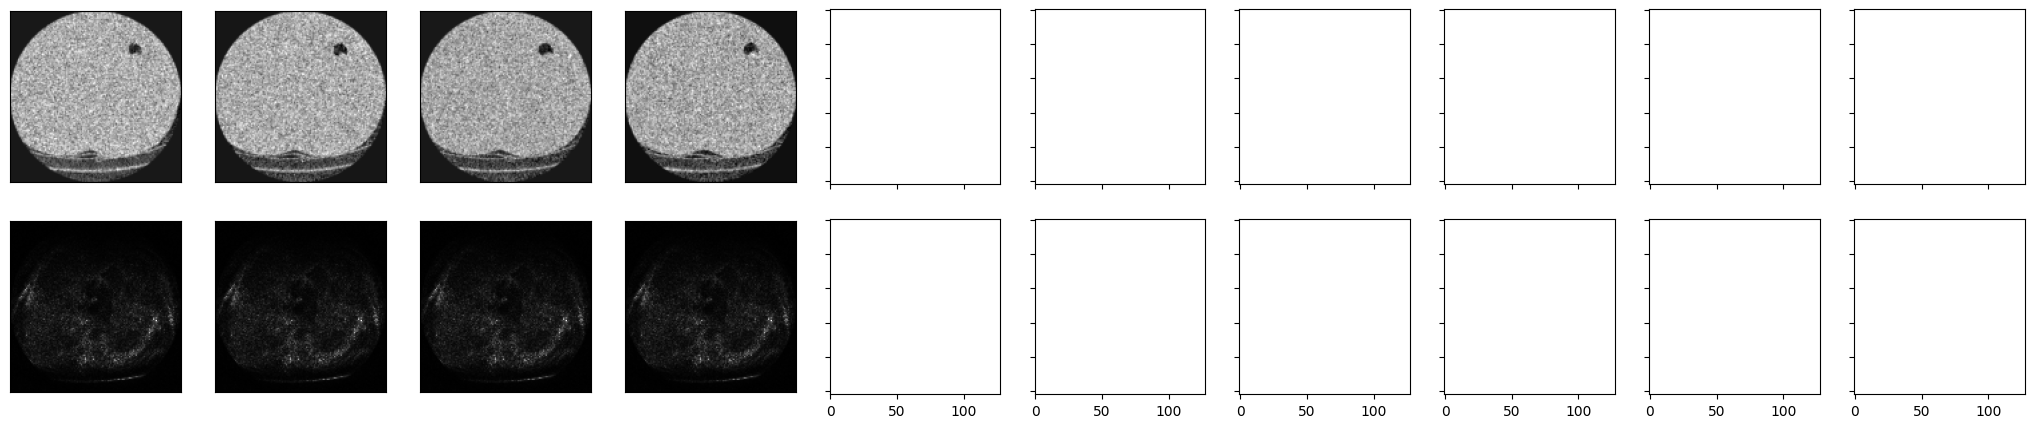

In [13]:
display_images(images, reconstructions)